<a href="https://colab.research.google.com/github/JhngJng/Summer_Internship_2021/blob/main/Implementations/GCN_Simple_Implementations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GCN Simple Implementations

Data Science & Artificial Intelligence Lab 2021 Summer Internship
Jihyeong Jung, Department of Mathematical Sciences, KAIST



#### Reference
1. https://github.com/tkipf/pygcn/tree/master/pygcn

In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/gdrive')

root = '/gdrive/My Drive/Implementations_2021 Summer Internship/GCN'

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append(root)

Mounted at /gdrive


In [2]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim

### 1. Implementations : Some preliminaries and basic models

In [3]:
### some utility code; code reference : https://github.com/tkipf/pygcn/blob/master/pygcn/utils.py
### encode_onehot function
def encode_onehot(labels):
  classes = set(labels)
  classes_dict = {}
  for i, c in enumerate(classes):
    classes_dict[c] = np.identity(len(classes))[i, :]
  labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
  return labels_onehot

### normalization function
def normalize(mx):
  """Row-normalize sparse matrix"""
  rowsum = np.array(mx.sum(1))
  r_inv = np.power(rowsum, -1).flatten()
  r_inv[np.isinf(r_inv)] = 0.
  r_mat_inv = sp.diags(r_inv)
  mx = r_mat_inv.dot(mx)
  return mx

### Accuracy function
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

### 
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

### loading data
import scipy.sparse as sp
def load_data():
  print('Loading Dataset Cora...')
  file1 = root+"/Data/cora.content"
  file2 = root+"/Data/cora.cites"

  ix_features_labels = np.genfromtxt(file1, dtype=np.dtype(str))
  features = sp.csr_matrix(ix_features_labels[:, 1:-1], dtype=np.float32)
  labels = encode_onehot(ix_features_labels[:, -1])

  # - building graph
  ix = np.array(ix_features_labels[:, 0], dtype=np.int32)
  ix_map = {j: i for i, j in enumerate(ix)}
  edges_unordered = np.genfromtxt(file2, dtype=np.int32)
  edges = np.array(list(map(ix_map.get, edges_unordered.flatten())), dtype=np.int32).reshape(edges_unordered.shape)
  adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:,0], edges[:,1])),
                      shape=(labels.shape[0], labels.shape[0]), dtype=np.float32)

  # build symmetric adjacency matrix(symmetric)
  adj = adj + adj.T.multiply(adj.T>adj) - adj.multiply(adj.T>adj)

  features = normalize(features)
  adj = normalize(adj + sp.eye(adj.shape[0]))

  ix_train = range(140)
  ix_val = range(200, 500)
  ix_test = range(500, 1500)

  features = torch.FloatTensor(np.array(features.todense()))
  labels = torch.LongTensor(np.where(labels)[1])
  adj = sparse_mx_to_torch_sparse_tensor(adj)

  ix_train = torch.LongTensor(ix_train)
  ix_val = torch.LongTensor(ix_val)
  ix_test = torch.LongTensor(ix_test)

  print('Dataset loading complete.')

  return adj, features, labels, ix_train, ix_val, ix_test
###


In [4]:
### Code reference : https://github.com/tkipf/pygcn/blob/master/pygcn/layers.py
### Defining Graph convolutional layer

import math
from torch.nn import Parameter
from torch.nn import Module

class GraphConv(Module):

  def __init__(self, in_channels, out_channels, bias=True):
    super(GraphConv, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.weight = Parameter(torch.FloatTensor(in_channels, out_channels))

    if bias == True:
      self.bias = Parameter(torch.FloatTensor(out_channels))
    else:
      self.register_parameter('bias', None)

    self.param_init() # parameter initialization based on LeCun's uniform initialization

  def param_init(self):
    stdev = 1.0/math.sqrt(self.weight.size(1))
    torch.nn.init.uniform_(self.weight,-stdev, stdev)
    if self.bias is not None:
      torch.nn.init.uniform_(self.bias,-stdev, stdev)
    
  def forward(self, X, A):
    X = torch.mm(X, self.weight)
    X = torch.sparse.mm(A, X)\

    if self.bias is not None:
      out = X + self.bias
    
    return out

    def __repr__(self):
      return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'
###

In [5]:
### Code Reference : https://github.com/tkipf/pygcn/blob/master/pygcn/models.py
### Defining the Model, GCN

class GCN(Module):
  def __init__(self, c, h, f):
    super(GCN, self).__init__()

    self.layer1 = GraphConv(c, h)
    self.layer2 = GraphConv(h, f)
    
  def forward(self, X, A):
    X = F.relu(self.layer1.forward(X, A))
    X = F.dropout(X, training=self.training)
    X = self.layer2.forward(X, A)
    return X


In [6]:
### Code Reference : https://github.com/tkipf/pygcn/blob/master/pygcn/train.py
### The Experiment Process, with dataset 'Cora'
# about model.eval(), etc : https://bluehorn07.github.io/2021/02/27/model-eval-and-train.html

import time

cuda = True if torch.cuda.is_available() else False

# hyperparameters
epochs = 200
learning_rate = 0.01
weight_decay = 0.0005
num_hidden = 16

# loading data
A, features, labels, ix_train, ix_val, ix_test = load_data()

# defining the model & optimizer
model = GCN(c=features.shape[1], h=num_hidden, f=labels.max().item()+1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

if cuda:
  model.cuda()
  features = features.cuda()
  A = A.cuda()
  labels = labels.cuda()
  ix_train = ix_train.cuda()
  ix_val = ix_val.cuda()
  ix_test = ix_test.cuda()


# records
train_losses = []
valid_losses = []

# training
def train(epoch):
  # training process
  t = time.time()
  model.train() # set to training mode
  logits = model.forward(features, A)
  train_loss = F.cross_entropy(logits[ix_train], labels[ix_train])
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()
  train_acc = accuracy(logits[ix_train], labels[ix_train])
  train_losses.append(train_loss)

  # validation process
  model.eval() # set to evaluation mode
  logits = model.forward(features, A)
  valid_loss = F.cross_entropy(logits[ix_val], labels[ix_val])
  valid_acc = accuracy(logits[ix_val], labels[ix_val])
  valid_losses.append(valid_loss)

  print('Epoch: {:04d}'.format(epoch+1),
          'train_loss: {:.4f}'.format(train_loss.item()),
          'train_acc: {:.4f}'.format(train_acc.item()),
          'valid_loss: {:.4f}'.format(valid_loss.item()),
          'valid_acc: {:.4f}'.format(valid_acc.item()),
          'time: {:.4f}s'.format(time.time() - t))

# test
def test():
  model.eval()
  logits = model(features, A)
  test_loss = F.cross_entropy(logits[ix_test], labels[ix_test])
  test_acc = accuracy(logits[ix_test], labels[ix_test])
  print("Test set results:",
          "loss= {:.4f}".format(test_loss.item()),
          "accuracy= {:.4f}".format(test_acc.item()))
  

# Running the experiment
total_time = time.time()
print('Training started...')
for epoch in range(epochs):
  train(epoch)
print('Training is done.')
print('Total time elapsed: {:4f}s'.format(time.time()-total_time))

test()

Loading Dataset Cora...
Dataset loading complete.
Training started...
Epoch: 0001 train_loss: 1.9923 train_acc: 0.1357 valid_loss: 1.9606 valid_acc: 0.1267 time: 0.1886s
Epoch: 0002 train_loss: 1.9688 train_acc: 0.1571 valid_loss: 1.9427 valid_acc: 0.1267 time: 0.0086s
Epoch: 0003 train_loss: 1.9438 train_acc: 0.1429 valid_loss: 1.9257 valid_acc: 0.1267 time: 0.0127s
Epoch: 0004 train_loss: 1.9375 train_acc: 0.1214 valid_loss: 1.9096 valid_acc: 0.1267 time: 0.0090s
Epoch: 0005 train_loss: 1.9282 train_acc: 0.1214 valid_loss: 1.8939 valid_acc: 0.1467 time: 0.0076s
Epoch: 0006 train_loss: 1.9032 train_acc: 0.2071 valid_loss: 1.8784 valid_acc: 0.3567 time: 0.0073s
Epoch: 0007 train_loss: 1.8909 train_acc: 0.1786 valid_loss: 1.8632 valid_acc: 0.3500 time: 0.0084s
Epoch: 0008 train_loss: 1.8676 train_acc: 0.2643 valid_loss: 1.8480 valid_acc: 0.3500 time: 0.0079s
Epoch: 0009 train_loss: 1.8550 train_acc: 0.3071 valid_loss: 1.8331 valid_acc: 0.3500 time: 0.0075s
Epoch: 0010 train_loss: 1.8436

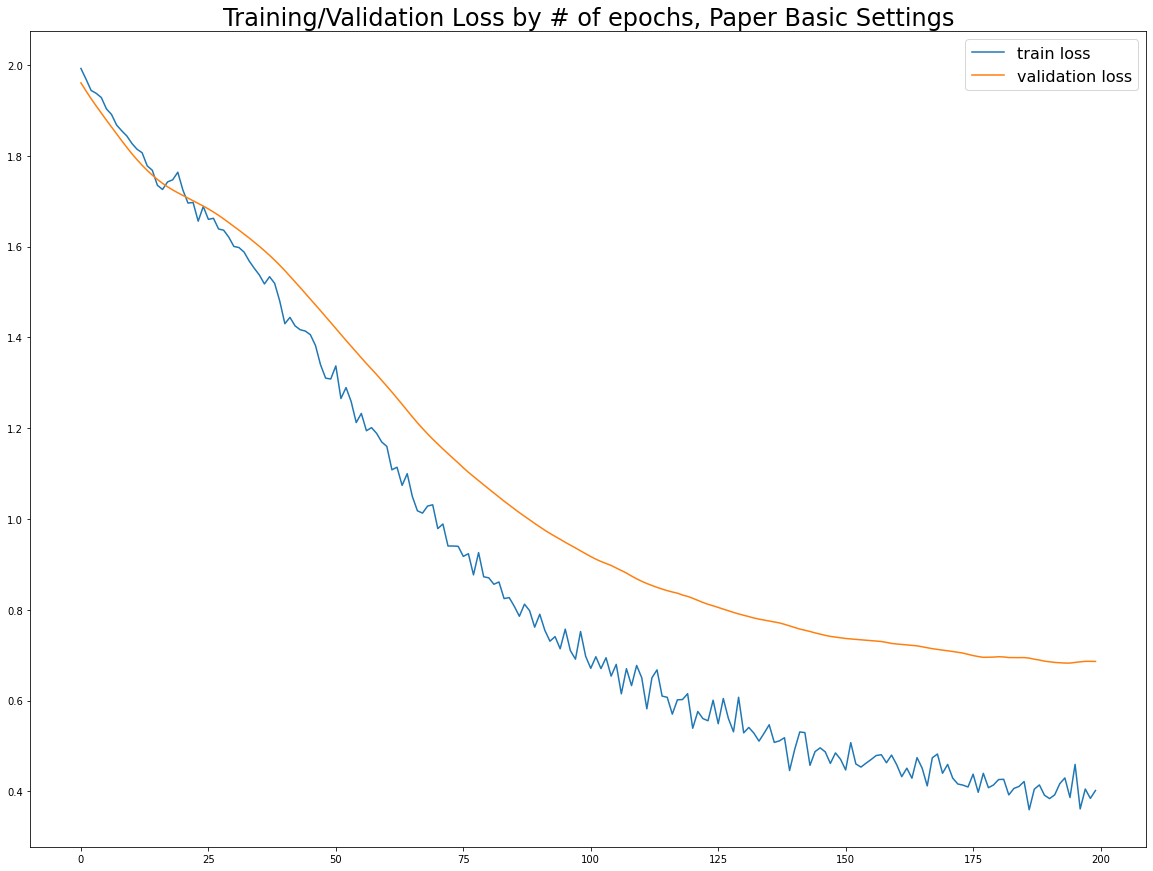

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='validation loss')
plt.title("Training/Validation Loss by # of epochs, Paper Basic Settings", fontsize=24)
plt.legend(fontsize=16)

### 2. Some modifications to model : Try deeper models, etc

In [9]:
### Defining the Modified version of given Model, GCN
### Added more layers (2 more layers here)

class ModifiedGCN(Module):
  def __init__(self, c, h1, h2, h3, f):
    super(ModifiedGCN, self).__init__()

    self.layer1 = GraphConv(c, h1)
    self.layer2 = GraphConv(h1, h2)
    self.layer3 = GraphConv(h2, h3)
    self.layer4 = GraphConv(h3, f)
    
  def forward(self, X, A):
    X = F.relu(self.layer1.forward(X, A))
    X = F.dropout(X, training=self.training)
    X = F.relu(self.layer2.forward(X, A))
    X = F.dropout(X, training=self.training)
    X = F.relu(self.layer3.forward(X, A))
    X = F.dropout(X, training=self.training)
    X = self.layer4.forward(X, A)
    return X

In [10]:
### Experiments with modified model
import time

cuda = True if torch.cuda.is_available() else False

# hyperparameters
epochs = 200
learning_rate = 0.01
weight_decay = 0.0005
num_hidden1 = 16
num_hidden2 = 32
num_hidden3 = 64

# loading data
A, features, labels, ix_train, ix_val, ix_test = load_data()

# defining the model & optimizer
model = ModifiedGCN(c=features.shape[1], h1=num_hidden1, h2=num_hidden2,
                    h3=num_hidden3, f=labels.max().item()+1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

if cuda:
  model.cuda()
  features = features.cuda()
  A = A.cuda()
  labels = labels.cuda()
  ix_train = ix_train.cuda()
  ix_val = ix_val.cuda()
  ix_test = ix_test.cuda()


# records
train_losses = []
valid_losses = []

# training
def train(epoch):
  # training process
  t = time.time()
  model.train() # set to training mode
  logits = model.forward(features, A)
  train_loss = F.cross_entropy(logits[ix_train], labels[ix_train])
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()
  train_acc = accuracy(logits[ix_train], labels[ix_train])
  train_losses.append(train_loss)

  # validation process
  model.eval() # set to evaluation mode
  logits = model.forward(features, A)
  valid_loss = F.cross_entropy(logits[ix_val], labels[ix_val])
  valid_acc = accuracy(logits[ix_val], labels[ix_val])
  valid_losses.append(valid_loss)

  print('Epoch: {:04d}'.format(epoch+1),
          'train_loss: {:.4f}'.format(train_loss.item()),
          'train_acc: {:.4f}'.format(train_acc.item()),
          'valid_loss: {:.4f}'.format(valid_loss.item()),
          'valid_acc: {:.4f}'.format(valid_acc.item()),
          'time: {:.4f}s'.format(time.time() - t))

# test
def test():
  model.eval()
  logits = model(features, A)
  test_loss = F.cross_entropy(logits[ix_test], labels[ix_test])
  test_acc = accuracy(logits[ix_test], labels[ix_test])
  print("Test set results:",
          "loss= {:.4f}".format(test_loss.item()),
          "accuracy= {:.4f}".format(test_acc.item()))
  

# Running the experiment
total_time = time.time()
print('Training started...')
for epoch in range(epochs):
  train(epoch)
print('Training is done.')
print('Total time elapsed: {:4f}s'.format(time.time()-total_time))

test()

Loading Dataset Cora...
Dataset loading complete.
Training started...
Epoch: 0001 train_loss: 2.0326 train_acc: 0.1000 valid_loss: 1.9799 valid_acc: 0.1033 time: 0.0113s
Epoch: 0002 train_loss: 1.9824 train_acc: 0.1000 valid_loss: 1.9441 valid_acc: 0.1033 time: 0.0111s
Epoch: 0003 train_loss: 1.9503 train_acc: 0.1071 valid_loss: 1.9149 valid_acc: 0.1033 time: 0.0125s
Epoch: 0004 train_loss: 1.9189 train_acc: 0.1286 valid_loss: 1.8877 valid_acc: 0.1567 time: 0.0132s
Epoch: 0005 train_loss: 1.8825 train_acc: 0.2286 valid_loss: 1.8624 valid_acc: 0.1567 time: 0.0123s
Epoch: 0006 train_loss: 1.8582 train_acc: 0.3143 valid_loss: 1.8407 valid_acc: 0.3500 time: 0.0118s
Epoch: 0007 train_loss: 1.8487 train_acc: 0.2714 valid_loss: 1.8239 valid_acc: 0.3500 time: 0.0119s
Epoch: 0008 train_loss: 1.8341 train_acc: 0.2714 valid_loss: 1.8128 valid_acc: 0.3500 time: 0.0127s
Epoch: 0009 train_loss: 1.8171 train_acc: 0.2929 valid_loss: 1.8075 valid_acc: 0.3500 time: 0.0189s
Epoch: 0010 train_loss: 1.8224

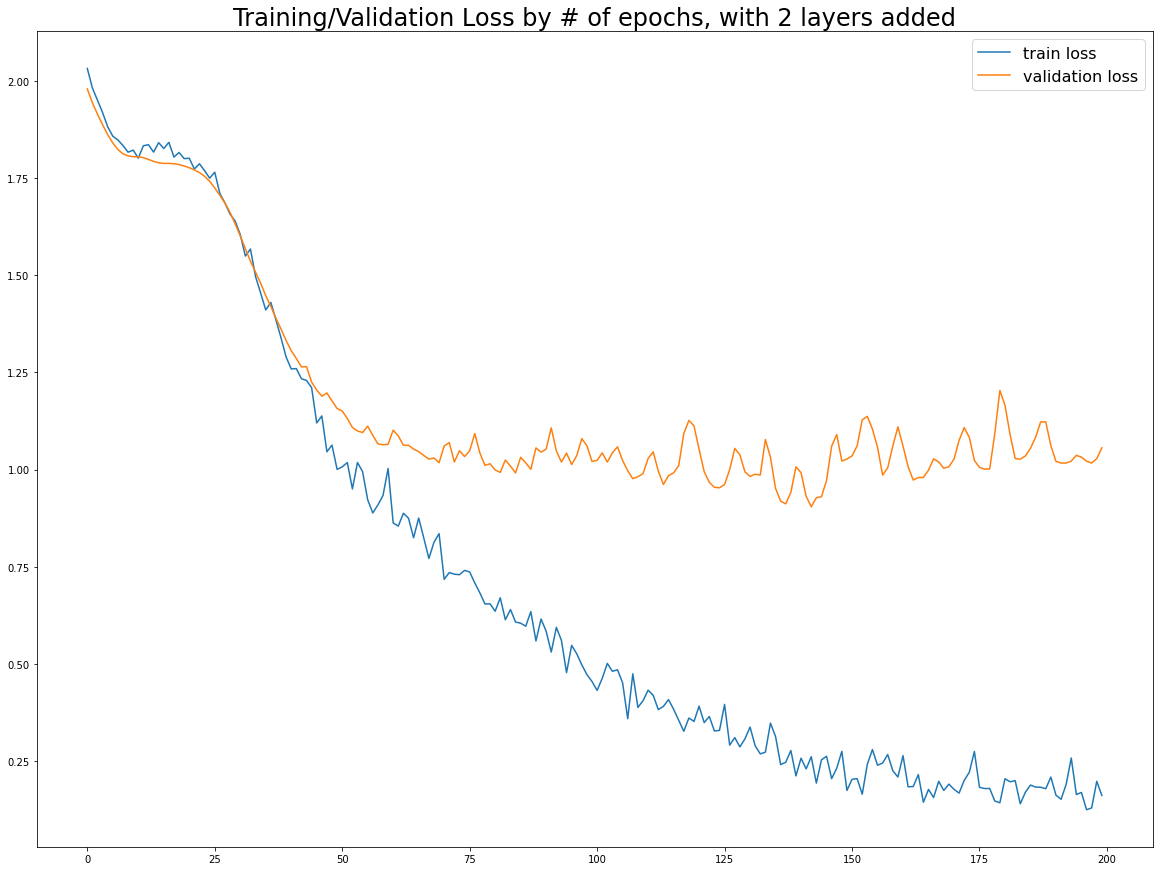

In [11]:
### plotting the loss graph
plt.figure(figsize=(20,15))
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='validation loss')
plt.title("Training/Validation Loss by # of epochs, with 2 layers added", fontsize=24)
plt.legend(fontsize=16)